# Tutorial: Extracting Maximum Storage Temperatures for Transistors from PDF Datasheets

# Introduction

In this tutorial, we will walk through the process of using `Fonduer` to identify mentions of the maximum storage temperature of transistors (e.g. `150°C`) in a corpus of transistor datasheets from [Digikey.com](https://www.digikey.com/products/en/discrete-semiconductor-products/transistors-bipolar-bjt-single/276).

The tutorial is broken into several parts, each covering a Phase of the `Fonduer` pipeline (as outlined in the [paper](https://arxiv.org/abs/1703.05028)), and the iterative KBC process:

1. KBC Initialization
2. Candidate Generation and Multimodal Featurization
3. Probabilistic Relation Classification
4. Error Analysis and Iterative KBC

In addition, we show how users can iteratively improve labeling functions to improve relation extraction quality.

# Phase 1: KBC Initialization

In this first phase of `Fonduer`'s pipeline, `Fonduer` uses a user specified _schema_ to initialize a relational database where the output KB will be stored. Furthermore, `Fonduer` iterates over its input _corpus_ and transforms each document into a unified data model, which captures the variability and multimodality of richly formatted data. This unified data model then servers as an intermediate representation used in the rest of the phases.

This preprocessed data is saved to a database. Connection strings can be specified by setting the `SNORKELDB` environment variable. If no database is specified, then SQLite at `./snorkel.db` is created by default. However, to enabled parallel execution, we use PostgreSQL throughout this tutorial.

We initialize several variables for convenience that define what the database should be called and what level of parallelization the `Fonduer` pipeline will be run with. In the code below, we use PostgreSQL as our database backend.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

PARALLEL = 4 # assuming a quad-core machine
ATTRIBUTE = "stg_temp_max"

os.environ['SNORKELDBNAME'] = ATTRIBUTE + '111'
os.environ['SNORKELDB'] = 'postgres://localhost:5432/' + os.environ['SNORKELDBNAME']
        
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/')

/Users/sen/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/Users/sen/.matplotlib/matplotlibrc", line #467
  (fname, cnt))


## 1.1 Defining a Candidate Schema

We first initialize a `SnorkelSession`, which manages the connection to the database automatically, and enables us to save intermediate results. This code also reinitializes each of the databases to ensure that we are starting fresh.

In [2]:
print os.system("dropdb " + os.environ['SNORKELDBNAME'])
print os.system("createdb " + os.environ['SNORKELDBNAME'])
print "SNORKELDB = %s" % os.environ['SNORKELDB']
print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']

from snorkel import SnorkelSession
session = SnorkelSession()

256
0
SNORKELDB = postgres://localhost:5432/stg_temp_max111
SNORKELDBNAME = stg_temp_max111


Next, we define the _schema_ of the relation we want to extract. This must be a subclass of Candidate, and we define it using a helper function. Here, we define a binary relation which connects two Span objects of text. This is what creates the relation's database table if it does not already exist.

In [3]:
from snorkel.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### 1.2 Parsing and Transforming the Input Documents into Unified Data Models

Next, we load the corpus of datasheets and transform them into the unified data model. Each datasheet has a PDF and HTML representation. Both representations are used in conjunction to create a robust unified data model with textual, structural, tabular, and visual modality information. Note that since each document is independent of each other, we can parse the documents in parallel. Note that parallel execution will not work with SQLite, the default database engine. We depend on PostgreSQL for this functionality.

#### Configuring an `HTMLPreprocessor`
We start by setting the paths to where our documents are stored, and defining a `HTMLPreprocessor` to read in the documents found in the specified paths. `max_docs` specified the number of documents to parse. For the sake of this tutorial, we only look at 50 documents.

**Note that you need to have run `download_data.sh` before executing these next steps or you won't have the documents needed for the tutorial.**

In [4]:
from snorkel.parser import HTMLPreprocessor, OmniParser

docs_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/html/'
pdf_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/pdf/'

doc_preprocessor = HTMLPreprocessor(docs_path, max_docs=50)

#### Configuring an `OmniParser`
Next, we configure an `OmniParser`, which serves as our `CorpusParser` for PDF documents. We use [CoreNLP](https://stanfordnlp.github.io/CoreNLP/) as a preprocessing tool to split our documents into phrases and tokens, and to provide annotations such as part-of-speech tags and dependency parse structures for these phrases. In addition, we can specify which modality information to include in the unified data model for each document. Below, we enable all modality information.

In [5]:
corpus_parser = OmniParser(structural=True, lingual=True, visual=True, pdf_path=pdf_path)
%time corpus_parser.apply(doc_preprocessor, parallelism=PARALLEL)

Clearing existing...
Running UDF...
CPU times: user 5.06 s, sys: 222 ms, total: 5.28 s
Wall time: 1min 34s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which `Fonduer` uses) to check how many documents and sentences were parsed, or even check how many phrases and tables are contained in each document.

In [6]:
from snorkel.models import Document, Phrase

print "Documents:", session.query(Document).count()
print "Phrases:", session.query(Phrase).count()

Documents: 50
Phrases: 20189


## 1.3 Dividing the Corpus into Test and Train

We'll split the documents 40/5/5 into train/dev/test splits. Note that here we do this in a non-random order to preverse the consistency in the tutorial, and we reference the splits by 0/1/2 respectively.

In [7]:
from snorkel.models import Document

docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

train_docs = set()
dev_docs   = set()
test_docs  = set()
splits = (0.8, 0.9)
for i,doc in enumerate(docs):
    if i < splits[0] * ld:
        train_docs.add(doc)
    elif i < splits[1] * ld:
        dev_docs.add(doc)
    else:
        test_docs.add(doc)

# Phase 2: Candidate Extraction & Multimodal Featurization
Given the unified data model from Phase 1, `Fonduer` extracts relation candidates based on user-provided **matchers** and **throttlers**. Then, `Fonduer` leverages the multimodality information captured in the unified data model to provide multimodal features for each candidate.

## 2.1: Candidate Extraction

The next step is to extract **candidates** from our corpus. A `candidate` is the objects for which we want to make predictions. In this case, the candidates are pairs of transistor part numbers and their corresponding maximum storage temperatures as found in their datasheets. Our task is to predict which pairs are true in the associated document.

To do so, we write **matchers** to define which spans of text in the corpus are instances of each entity. Matchers can leverage a variety of information from regular expressions, to dictionaries, to user-defined functions. Furthermore, different techniques can be combined to form higher quality matchers. In general, matchers should seek to be as precise as possible while maintaining complete recall.

In our case, we need to write a matcher that defines a transistor part number and a matcher to define a valid temperature value.

### Writing a simple temperature matcher

Our maximum storage temperature matcher can be a very simple regular expression since we know that we are looking for integers, and by inspecting a portion of our corpus, we see that maximum storage temperatures fall within a fairly narrow range.

In [8]:
from snorkel.matchers import *

attr_matcher = RegexMatchSpan(rgx=r'(?:[1][5-9]|20)[05]', longest_match_only=False)

### Writing an advanced transistor part matcher

In contrast, transistor part numbers are complex expressions. Here, we show how transistor part numbers can leverage [naming conventions](https://en.wikipedia.org/wiki/Transistor#Part_numbering_standards.2Fspecifications) as regular expressions, and use a dictionary of known part numbers, and use user-defined functions together. First, we create a regular expression matcher for standard transistor naming conventions.

In [9]:
### Transistor Naming Conventions as Regular Expressions ###
eeca_rgx = '([ABC][A-Z][WXYZ]?[0-9]{3,5}(?:[A-Z]){0,5}[0-9]?[A-Z]?(?:-[A-Z0-9]{1,7})?(?:[-][A-Z0-9]{1,2})?(?:\/DG)?)'
jedec_rgx = '(2N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jis_rgx = '(2S[ABCDEFGHJKMQRSTVZ]{1}[\d]{2,4})'
others_rgx = '((?:NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|ZXT|TIS|TIPL|DTC|MMBT|SMMBT|PZT|FZT|STD|BUV|PBSS|KSC|CXT|FCX|CMPT){1}[\d]{2,4}[A-Z]{0,5}(?:-[A-Z0-9]{0,6})?(?:[-][A-Z0-9]{0,1})?)'

part_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
part_rgx_matcher = RegexMatchSpan(rgx=part_rgx, longest_match_only=True)

Next, we can create a matcher from a dictionary of known part numbers:

In [10]:
import csv

def get_digikey_parts_set(path):
    """
    Reads in the digikey part dictionary and yeilds each part.
    """
    all_parts = set()
    with open(path, "r") as csvinput:
        reader = csv.reader(csvinput)
        for line in reader:
            (part, url) = line
            all_parts.add(part)
    return all_parts
            
### Dictionary of known transistor parts ###
dict_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/digikey_part_dictionary.csv'
part_dict_matcher = DictionaryMatch(d=get_digikey_parts_set(dict_path))

We can also use user-defined functions to further improve our matchers. For example, here we use patterns in the document filenames as a signal for whether a span of text in a document is a valid transistor part number.

In [11]:
def common_prefix_length_diff(str1, str2):
    for i in range(min(len(str1), len(str2))):
        if str1[i] != str2[i]:
            return min(len(str1), len(str2)) - i
    return 0

def part_file_name_conditions(attr):
    file_name = attr.sentence.document.name
    if len(file_name.split('_')) != 2: return False
    if attr.get_span()[0] == '-': return False
    name = attr.get_span().replace('-', '')
    return any(char.isdigit() for char in name) and any(char.isalpha() for char in name) and common_prefix_length_diff(file_name.split('_')[1], name) <= 2

add_rgx = '^[A-Z0-9\-]{5,15}$'

part_file_name_lambda_matcher = LambdaFunctionMatch(func=part_file_name_conditions)
part_file_name_matcher = Intersect(RegexMatchSpan(rgx=add_rgx, longest_match_only=True), part_file_name_lambda_matcher)

Then, we can union all of these matchers together to form our final part matcher.

In [12]:
part_matcher = Union(part_rgx_matcher, part_dict_matcher, part_file_name_matcher)

These two matchers define each entity in our relation schema.

### Define a relation's `ContextSpaces`

Next, in order to define the "space" of all candidates that are even considered from the document, we need to define a `ContextSpace` for each component of the relation we wish to extract.

In the case of transistor part numbers, the `ContextSpace` can be quite complex due to the need to handle implicit part numbers that are implied in text like "BC546A/B/C...BC548A/B/C", which refers to 9 unique part numbers. In addition, to handle these, we consider all n-grams up to 3 words long.

In contrast, the `ContextSpace` for temperature values is simpler: we only need to process different unicode representations of a (`-`), and don't need to look at more than two works at a time.

In [13]:
from hardware_spaces import OmniNgramsPart, OmniNgramsTemp
    
part_ngrams = OmniNgramsPart(parts_by_doc=None, n_max=3)
attr_ngrams = OmniNgramsTemp(n_max=2)

### Defining candidate `Throttlers`

Next, we need to define **throttlers**, which allow us to further prune excess candidates and avoid unnecessarily materializing invalid candidates. Trottlers, like matchers, act as hard filters, and should be created to have high precision while maintaining complete recall, if possible.

Here, we create a throttler that discards candidates if they are in the same table, but the part and storage temperature are not vertically or horizontally aligned.

In [14]:
from snorkel.contrib.fonduer.lf_helpers import *
import re

def stg_temp_throttler((part, attr)):
    if same_table((part, attr)):
        return (is_horz_aligned((part, attr)) or is_vert_aligned((part, attr)))
    return True

throttler = stg_temp_throttler

### Running the `CandidateExtractor`

Now, we have all the component necessary to perform candidate extraction. We have defined the "space" of things to consider for each candidate, provided matchers that signal when a valid mention is seen, and a throttler to prunes away excess candidates. We now can define the `CandidateExtractor` with the contexts to extract from, the matchers, and the throttler to use. 

In [15]:
from snorkel.candidates import CandidateExtractor


candidate_extractor = CandidateExtractor(Part_Attr, 
                        [part_ngrams, attr_ngrams], 
                        [part_matcher, attr_matcher], 
                        throttler=throttler)

%time candidate_extractor.apply(train_docs, split=0)

Clearing existing...
Running UDF...
[========================================] 100%
CPU times: user 12.7 s, sys: 477 ms, total: 13.2 s
Wall time: 14.9 s


Here we specified that these `Candidates` belong to the training set by specifying `split=0`; recall that we're referring to train/dev/test as splits 0/1/2.

In [16]:
train_cands = session.query(Part_Attr).filter(Part_Attr.split == 0).all()
print "Number of candidates:", len(train_cands)

Number of candidates: 1818


### Repeating for development and test splits
Finally, we rerun the same operation for the other two document divisions: dev and test. For each, we simply load the `Corpus` object and run them through the `CandidateExtractor`.

In [17]:
%%time
for i, docs in enumerate([dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i+1)
    print "Number of candidates:", session.query(Part_Attr).filter(Part_Attr.split == i+1).count()

Clearing existing...
Running UDF...
[========================================] 100%
Number of candidates: 106
Clearing existing...
Running UDF...
[========================================] 100%
Number of candidates: 335
CPU times: user 3.59 s, sys: 182 ms, total: 3.77 s
Wall time: 4.25 s


## 2.2 Multimodal Featurization
Unlike dealing with plain unstructured text, `Fonduer` deals with richly formatted data, and consequently featurizes each candidate with a baseline library of multimodal features. 

### Featurize with `Fonduer`'s optimized Postgres Feature Annotator
We now annotate the candidates in our dev, test, and training sets with features. The `BatchFeatureAnnotator` provided by `Fonduer` allows this to be done in parallel to improve performance.

`featurizer.apply` takes three important arguments.
* `split` defines which candidate set wer are dealing with. For example, `split=0` is the training set.
* `replace_key_set` determine whether or not replace, or reinitialize, the set of features to apply to candidates. That is, when `replace_key_set` is true, key set of features will be replaced with the key set of the features found in the split that is being processed.
* `parallelism` determines how many processes to run in parallel.

Notices that `replace_key_set=True` only for the first call to `featurizer.apply`, while the other calls have this parameter set to `False`. This is because we want to have the set of features we label candidates with defined by the features found in the set of training documents only. If a later call to `featurizer.apply` replaced the key set, then only the features of that particular split would be considered later in the pipeline.

In [18]:
from snorkel.contrib.fonduer.async_annotations import BatchFeatureAnnotator

featurizer = BatchFeatureAnnotator(Part_Attr)
%time F_train = featurizer.apply(split=0, replace_key_set=True, parallelism=PARALLEL)
print F_train.shape
%time F_dev = featurizer.apply(split=1, replace_key_set=False, parallelism=PARALLEL)
print F_dev.shape
%time F_test = featurizer.apply(split=2, replace_key_set=False, parallelism=PARALLEL)
print F_test.shape

Clearing existing...
Running UDF...
Copying part_attr_feature to postgres
COPY 1818

CPU times: user 4.06 s, sys: 199 ms, total: 4.26 s
Wall time: 1min 50s
(1818, 8128)
Clearing existing...
Running UDF...
Copying part_attr_feature_updates to postgres
COPY 106

CPU times: user 194 ms, sys: 49.8 ms, total: 244 ms
Wall time: 19.7 s
(106, 8128)
Clearing existing...
Running UDF...
Copying part_attr_feature_updates to postgres
COPY 335

CPU times: user 1.23 s, sys: 139 ms, total: 1.37 s
Wall time: 18.5 s
(335, 8128)


At the end of this phase, `Fonduer` has generated the set of candidates and the feature matrix. Note that Phase 1 and 2 are relatively static and typically are only executed once during the KBC process.

# Phase 3: Probabilistic Relation Classification
In this phase, `Fonduer` applies user-defined **labeling functions**, which express various heuristics, patterns, and [weak supervision](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html) strategies to label our data, to each of the candidates to create a label matrix that is used by our data programming engine.

In the wild, hand-labeled training data is rare and expensive. A common scenario is to have access to tons of unlabeled training data, and have some idea of how to label them programmatically. For example:
* We may be able to think of text patterns that would indicate a part and polarity mention are related, for example the word "polarity" appearing between them.
* We may have access to an external knowledge base that lists some pairs of parts and polarities, and can use these to noisily label some of our mention pairs.
Our labeling functions will capture these types of strategies. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will model their accuracies with a generative model, which `Fonduer` will help us easily apply.

Using data programming, we can then train machine learning models to learn which features are the most important in classifying candidates.

### Loading Gold Data
For convenience in error analysis and evaluation, we have already annotated the dev and test set for this tutorial, and we'll now load it using an externally-defined helper function.

Loading and saving external "gold" labels can be a bit messy, but is often a critical part of development, especially when gold labels are expensive and/or time-consuming to obtain. Snorkel stores all labels that are manually annotated in a **stable** format (called StableLabels), which is somewhat independent from the rest of Snorkel's data model, does not get deleted when you delete the candidates, corpus, or any other objects, and can be recovered even if the rest of the data changes or is deleted.

Our general procedure with external labels is to load them into the `StableLabel` table, then use `Fonduer`'s helpers to load them into the main data model from there. If interested in example implementation details, please see the script we now load:

In [19]:
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/hardware_tutorial_gold.csv'
load_hardware_labels(session, Part_Attr, gold_file, ATTRIBUTE ,annotator_name='gold')

Loading 2259 candidate labels
[========================================] 100%
AnnotatorLabels created: 2259


### Creating Labeling Functions

In `Fonduer`, our primary interface through which we provide training signal to the end extraction model we are training is by writing labeling functions (**LFs**) (as opposed to hand-labeling massive training sets).

A labeling function isn't anything special. It's just a Python function that accepts a `Candidate` as the input argument and returns `1` if it says the Candidate should be marked as true, `-1` if it says the `Candidate` should be marked as false, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are unipolar: it labels only 1s and 0s, or it labels only -1s and 0s.

Recall that our goal is to ultimately train a high-performance classification model that predicts which of our Candidates are true mentions of spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

TODO Add more explanation of LFs

In [20]:
from snorkel.contrib.fonduer.lf_helpers import *
import re

def LF_storage_row(c):
    return 1 if 'storage' in get_row_ngrams(c.attr) else 0

def LF_operating_row(c):
    return 1 if 'operating' in get_row_ngrams(c.attr) else 0

def LF_temperature_row(c):
    return 1 if 'temperature' in get_row_ngrams(c.attr) else 0

def LF_tstg_row(c):
    return 1 if overlap(
        ['tstg','stg','ts'], 
        list(get_row_ngrams(c.attr))) else 0

def LF_not_temp_relevant(c):
    return -1 if not overlap(
        ['storage','temperature','tstg','stg', 'ts'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_temp_outside_table(c):
    return -1 if not c.attr.is_tabular() is None else 0

def LF_too_many_numbers_row(c):
    num_numbers = list(get_row_ngrams(c.attr, attrib="ner_tags")).count('number')
    return -1 if num_numbers >= 3 else 0

def LF_collector_aligned(c):
    return -1 if overlap(
        ['collector', 'collector-current', 'collector-base', 'collector-emitter'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_current_aligned(c):
    ngrams = get_aligned_ngrams(c.attr)
    return -1 if overlap(
        ['current', 'dc', 'ic'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_voltage_row_temp(c):
    ngrams = get_aligned_ngrams(c.attr)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_voltage_row_part(c):
    ngrams = get_aligned_ngrams(c.part)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_typ_row(c):
    return -1 if overlap(
        ['typ', 'typ.'],
        list(get_row_ngrams(c.attr))) else 0

def LF_test_condition_aligned(c):
    return -1 if overlap(
        ['test', 'condition'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_complement_left_row(c):
    return -1 if (
        overlap(['complement','complementary'], 
        chain.from_iterable([get_row_ngrams(c.part), get_left_ngrams(c.part, window=10)]))) else 0

def LF_temp_on_high_page_num(c):
    return -1 if c.attr.get_attrib_tokens('page')[0] > 2 else 0

def LF_to_left(c):
    return 1 if 'to' in get_left_ngrams(c.attr, window=2) else 0

def LF_negative_number_left(c):
    return 1 if any([re.match(r'-\s*\d+', ngram) for ngram in get_left_ngrams(c.attr, window=4)]) else 0



stg_temp_lfs = [
    LF_storage_row,
    LF_operating_row,
    LF_temperature_row,
    LF_tstg_row,
    LF_not_temp_relevant,
    LF_temp_outside_table,
    LF_too_many_numbers_row,
    LF_collector_aligned,
    LF_current_aligned,
    LF_voltage_row_temp,
    LF_voltage_row_part,
    LF_typ_row,
    LF_test_condition_aligned,
    LF_complement_left_row,
    LF_temp_on_high_page_num,
    LF_to_left,
    LF_negative_number_left
]

### Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database. We'll do this using the `LabelAnnotator` class, a `UDF` which we will again run with `UDFRunner`. Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set. Also note that we are using `Fonduer`'s optimized batch label annotator, which runs in parallel and depends on having Postgres as the backend database. 

In [21]:
from snorkel.contrib.fonduer.async_annotations import BatchLabelAnnotator

labeler = BatchLabelAnnotator(Part_Attr, lfs = stg_temp_lfs)
%time L_train = labeler.apply(split=0, parallelism=4)
print L_train.shape

# # Update existing labels, assume the lfs are updated
# def LF_test(c):
#     return 1 if 'to' in get_left_ngrams(c.attr, window=2) else 0
# stg_temp_lfs3 = [LF_test]
# labeler = BatchLabelAnnotator(Part_Attr, lfs = stg_temp_lfs3)
# %time L_train = labeler.apply(split=0, clear=False, update_keys=True, update_values=True, parallelism=4)
# print L_train.shape
# L_train3 = L_train

Clearing existing...
Running UDF...
Copying part_attr_label to postgres
COPY 1818

CPU times: user 177 ms, sys: 54.5 ms, total: 232 ms
Wall time: 41.2 s
(1818, 17)


Note that the returned matrix is a special subclass of the scipy.sparse.csr_matrix class, with some special features which we demonstrate below:

In [22]:
L_train.get_candidate(session, 0)

Part_Attr(Span("BC848", sentence=3680, chars=[4,8], words=[1,1]), ImplicitSpan("200", sentence=34362, words=[0,0], position=[0]))

We can also view statistics about the resulting label matrix.
* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

In addition, because we have already loaded the gold labels, we can view the emperical accuracy of these labeling functions when compared to our gold labels:

In [23]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
%time L_train.lf_stats(L_gold_train)

CPU times: user 27.2 ms, sys: 633 µs, total: 27.8 ms
Wall time: 27.8 ms


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_typ_row,0,0.003300,0.003300,0.000000,0,0,1,5,0.833333
LF_voltage_row_part,1,0.226073,0.226073,0.036304,0,0,91,320,0.778589
LF_collector_aligned,2,0.040154,0.040154,0.000000,0,0,10,63,0.863014
LF_operating_row,3,0.055006,0.055006,0.055006,84,16,0,0,0.840000
LF_temp_outside_table,4,1.000000,1.000000,0.171617,0,0,410,1408,0.774477
LF_complement_left_row,5,0.077008,0.077008,0.022552,0,0,2,138,0.985714
LF_current_aligned,6,0.337184,0.337184,0.000000,0,0,59,554,0.903752
LF_tstg_row,7,0.113861,0.113861,0.113861,155,52,0,0,0.748792
LF_not_temp_relevant,8,0.822332,0.822332,0.000000,0,0,168,1327,0.887625
LF_voltage_row_temp,9,0.226073,0.226073,0.036304,0,0,91,320,0.778589


### Fitting the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [24]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.9, step_size=0.001/L_train.shape[0], reg_param=0)

/Users/sen/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


CPU times: user 34.8 s, sys: 77.7 ms, total: 34.9 s
Wall time: 34.9 s


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [25]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

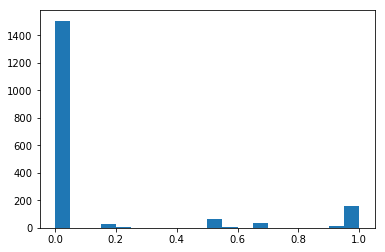

In [26]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters as well.

In [27]:
gen_model.weights.lf_accuracy()

array([ 0.72150771,  0.71061659,  0.71263153,  0.733347  ,  0.71549976,
        0.72218097,  0.71623716,  0.74805679,  0.75052034,  0.74054783,
        0.73726914,  0.72245591,  0.72774453,  0.71953481,  0.7248585 ,
        0.73432181,  0.74491366])

### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [28]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%
Copying part_attr_label_updates to postgres
COPY 106



Then, we get the score of the generative model:

In [30]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.293
Neg. class accuracy: 0.969
Precision            0.857
Recall               0.293
F1                   0.436
----------------------------------------
TP: 12 | FP: 2 | TN: 63 | FN: 29



We can also view statistics about the labeling function's learned accuracy and compare them to the emperical accuracy.

In [31]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_dev.lf_stats(L_gold_dev, gen_model.weights.lf_accuracy())

/Users/sen/Documents/Sen/Stanford/Deepdive/snorkel/snorkel/contrib/fonduer/async_annotations.py:91: RuntimeWarning: invalid value encountered in divide
  ac = (tp+tn).astype(float) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_typ_row,0,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.721508
LF_voltage_row_part,1,0.254717,0.254717,0.000000,0,0,14,13,0.481481,0.710617
LF_collector_aligned,2,0.075472,0.075472,0.000000,0,0,2,6,0.750000,0.712632
LF_operating_row,3,0.066038,0.066038,0.066038,6,1,0,0,0.857143,0.733347
LF_temp_outside_table,4,1.000000,1.000000,0.141509,0,0,41,65,0.613208,0.715500
LF_complement_left_row,5,0.075472,0.075472,0.018868,0,0,0,8,1.000000,0.722181
LF_current_aligned,6,0.339623,0.339623,0.000000,0,0,19,17,0.472222,0.716237
LF_tstg_row,7,0.103774,0.103774,0.103774,9,2,0,0,0.818182,0.748057
LF_not_temp_relevant,8,0.858491,0.858491,0.000000,0,0,29,62,0.681319,0.750520
LF_voltage_row_temp,9,0.254717,0.254717,0.000000,0,0,14,13,0.481481,0.740548


### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!

In fact, it is probably somewhat overfit to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).


### Training the Discriminative Model
Now, we'll use the noisy training labels we generated in the last part to train our end extraction model. For this tutorial, we will be training a simple - but fairly effective - logistic regression model. More generally, however, Snorkel plugs in with many ML libraries including [TensorFlow](https://www.tensorflow.org/), making it easy to use almost any state-of-the-art model as the end extractor!

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. 

In [32]:
from snorkel.learning import SparseLogisticRegression

disc_model = SparseLogisticRegression()
%time disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)

[SparseLR] lr=0.001 l1=0.0 l2=0.0
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=1818  #epochs=200  batch size=100
[SparseLR] Epoch 0 (0.42s)	Avg. loss=0.447692	NNZ=8128
[SparseLR] Epoch 5 (1.68s)	Avg. loss=0.107927	NNZ=8128
[SparseLR] Epoch 10 (2.83s)	Avg. loss=0.082236	NNZ=8128
[SparseLR] Epoch 15 (4.07s)	Avg. loss=0.073997	NNZ=8128
[SparseLR] Epoch 20 (5.20s)	Avg. loss=0.070308	NNZ=8128
[SparseLR] Epoch 25 (6.33s)	Avg. loss=0.068349	NNZ=8128
[SparseLR] Epoch 30 (7.57s)	Avg. loss=0.067187	NNZ=8128
[SparseLR] Epoch 35 (8.70s)	Avg. loss=0.066442	NNZ=8128
[SparseLR] Epoch 40 (9.82s)	Avg. loss=0.065933	NNZ=8128
[SparseLR] Epoch 45 (11.06s)	Avg. loss=0.065569	NNZ=8128
[SparseLR] Epoch 50 (12.24s)	Avg. loss=0.065297	NNZ=8128
[SparseLR] Epoch 55 (13.40s)	Avg. loss=0.065089	NNZ=8128
[SparseLR] Epoch 60 (14.63s)	Avg. loss=0.064925	NNZ=8128
[SparseLR] Epoch 65 (15.76s)	Avg. loss=0.064794	NNZ=8128
[SparseLR] Epoch 70 (16.89s)	Avg. loss=0.064686	NNZ=8128
[SparseLR] Epoc

### Evaluating on the Test Set
In this final section, we'll get the score we've been after: the performance of the extraction model on the blind test set (split 2). First, we load the test set labels and gold candidates from earlier:

In [33]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

Now, we score using the discriminitive model:

In [34]:
tp, fp, tn, fn = disc_model.score(session, F_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.323
Neg. class accuracy: 0.987
Precision            0.912
Recall               0.323
F1                   0.477
----------------------------------------
TP: 31 | FP: 3 | TN: 236 | FN: 65



In [35]:
from hardware_utils import entity_level_f1
import os

import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/parts_by_doc_dict.pkl'
with open(pickle_file, 'r') as f:
    parts_by_doc = pickle.load(f)

%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, test_docs, parts_by_doc=parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.918
Corpus Recall    0.662
Corpus F1        0.769
----------------------------------------
TP: 45 | FP: 4 | FN: 23

CPU times: user 379 ms, sys: 34.7 ms, total: 414 ms
Wall time: 471 ms


# Error Analysis & Iterative KBC

During the development process, we can iteratively improve the quality of our labeling functions through error analysis, without executing the full pipeline as in previous techniques. 

## Error Analysis
Understanding common errors. Which document has most problems, etc 

## Iteratively Improving Labeling Functions
Armed with the information learned from error analysis, we can improve labeling functions and return from [Creating Labeling Functions](http://localhost:8888/notebooks/tutorials/fonduer/hardware/max_storage_temp_tutorial.ipynb#Creating-Labeling-Functions).

TODO:
- Error analysis
- Updating LF, have user run again

In [36]:
FN

[('BC546-D', 'BC547', '150'),
 ('BC546-D', 'BC547B', '150'),
 ('BC546-D', 'BC547BG', '150'),
 ('BC546-D', 'BC547BRL1G', '150'),
 ('BC546-D', 'BC547BZL1G', '150'),
 ('BC546-D', 'BC547C', '150'),
 ('BC546-D', 'BC547CG', '150'),
 ('BC546-D', 'BC547CZL1G', '150'),
 ('BC546-D', 'BC548', '150'),
 ('BC546-D', 'BC548C', '150'),
 ('BC546-D', 'BC548CG', '150'),
 ('BC546-D', 'BC548CZL1G', '150'),
 ('BC546_DIOTEC', 'BC547', '150'),
 ('BC546_DIOTEC', 'BC547A', '150'),
 ('BC546_DIOTEC', 'BC547B', '150'),
 ('BC546_DIOTEC', 'BC547C', '150'),
 ('BC546_DIOTEC', 'BC548', '150'),
 ('BC546_DIOTEC', 'BC548B', '150'),
 ('BC546_DIOTEC', 'BC548C', '150'),
 ('BC550', 'BC547', '150'),
 ('BC550', 'BC547A', '150'),
 ('BC550', 'BC547B', '150'),
 ('BC550', 'BC547C', '150')]

In [37]:
fn_cand = fn_list[20]

from hardware_utils import part_error_analysis
part_error_analysis(fn_cand)

NameError: name 'fn_list' is not defined